## Individual Recommender system
Running the cell below you can actually put the individual recommender system in practice. Do not add any actual code about the recommenders in this notebook, do that in 'recommender.ipynb' and then import the necessary methods you need. (ask chatgpt how to do so) 

In [3]:

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import numpy as np
import csv
import keyboard
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from numpy.linalg import norm



c:\Users\Alvaro\AppData\Local\Programs\Python\Python310\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [11]:
ratings_df = pd.read_csv('Data/filtered_ratings.csv')
movies = pd.read_csv('Data/movies.csv')
# model = Word2Vec.load("Data\glove.6B.50d.txt")


print(len(ratings_df))

1476409


In [ ]:
import numpy as np

def load_glove_vectors(glove_file):
    word_to_vec = {}
    with open(glove_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            word_to_vec[word] = vector
    return word_to_vec

def word_to_vector(word, word_to_vec):
    word = word.lower()  # Ensure the word is in lowercase for consistent lookup
    if word in word_to_vec:
        return word_to_vec[word]
    else:
        # Handle the case where the word is not in the vocabulary
        return None

# Example usage:
glove_file = 'Data\glove.6B.50d.txt'  # Replace with the path to your GloVe file
word_to_vec = load_glove_vectors(glove_file)

word = 'apple'
vector = word_to_vector(word, word_to_vec)

def cosine_similarity(vector1, vector2):
    cosine = np.dot(vector1,vector2)/(norm(vector1)*norm(vector2))
    return cosine
    
def compute_word_similarity(word1, word2, word_to_vec):
    if word1 not in word_to_vec or word2 not in word_to_vec:
        return None

    vector1 = word_to_vec[word1]
    vector2 = word_to_vec[word2]
    similarity = cosine_similarity(vector1, vector2)

    return similarity



In [134]:
print(compute_word_similarity("1900", "19th century", word_to_vec))
print(compute_word_similarity("shoe", "frog", word_to_vec))


None
0.13727288


In [5]:
def get_movie_name(movie_id, movies_df):
    movie_row = movies_df[movies_df['movieId'] == movie_id]

    if not movie_row.empty:
        return movie_row['title'].iloc[0]
    else:
        return "Movie not in the list"

In [8]:
def newUser(movie_ratings):
    new_user_id = 1
    
    # Find the next available user ID
    with open('Data/filtered_ratings.csv', mode='r', newline='') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)  # Skip the header row
        existing_user_ids = set()
        for row in csv_reader:
            existing_user_ids.add(int(row[0]))
        while new_user_id in existing_user_ids:
            new_user_id += 1

    # Write the new user's ratings to the CSV file, each in a separate row
    with open('Data/filtered_ratings.csv', mode='a', newline='') as file:
        writer = csv.writer(file)
        for movie_id, rating in movie_ratings.items():
            writer.writerow([new_user_id, movie_id, rating])
    return new_user_id

In [9]:
import random
def recommendKNN(movie_ratings, new_user_id):
    # Filter users with more than 200 ratings
#     user_ratings = pd.Series(movie_ratings)
#     users_ratings = ratings_df.groupby('userId').count()
#     selected_users = users_ratings[users_ratings['rating'] > 200].index.tolist()
    
    # Select a random user
#     selected_user = random.choice(selected_users)
    selected_user = new_user_id
    
    # Filter ratings for the selected user
    selected_user_ratings = ratings_df[ratings_df['userId'] == selected_user]
    
    # Merge ratings with movie data
    rated_movies_df = movies.merge(selected_user_ratings, on='movieId', how='inner')
    
    # Create TF-IDF vectors for movie genres
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(rated_movies_df['genres'])
    y = rated_movies_df['rating']
    
    # Train KNN Regressor
    neighbors = 0
    if(len(movie_ratings)< 5):
       neighbors = len(movie_ratings)
    nighbors = 5
    neigh = KNeighborsRegressor(n_neighbors=neighbors)
    neigh.fit(X, y)
    
    # Predict ratings for unrated movies
    unrated_movies = movies[~movies['movieId'].isin(rated_movies_df['movieId'])]
    X_unrated = vectorizer.transform(unrated_movies['genres'])
    y_unrated = neigh.predict(X_unrated)
    
    # Create a dictionary with movie IDs and predicted ratings
    predicted_ratings = dict(zip(unrated_movies['movieId'], y_unrated))
    
    # Combine user ratings and predicted ratings
    user_and_predicted_ratings = {**movie_ratings, **predicted_ratings}
    
    # Sort the movies based on the combined ratings
    sorted_movies = sorted(user_and_predicted_ratings.items(), key=lambda x: x[1], reverse=True)
    common_movie_count = 0
    for i, (movie_id, rating) in enumerate(sorted_movies[common_movie_count:10+ common_movie_count], 1):
        if movie_id not in movie_ratings:
            common_movie_count += 1
            print(f"{i}. Movie : {get_movie_name(movie_id)}, Rating: {rating}")
    return sorted_movies

In [12]:
def compute_similarity(genre_rating, contains_genre):
    return 2.75 if not contains_genre else genre_rating

def getMovieGenres(movie_id):
    movie_row = movies[movies['movieId'] == movie_id]

    if not movie_row.empty:
        genres_str = movie_row['genres'].iloc[0]
        
        genres_list = genres_str.split('|')
        
        return genres_list
    else:
        return []
        
def getGenresDict(genres, movie_id):
    movieGenres = getMovieGenres(movie_id)
    genresDict = {}
    for genre, rating in genres.items(): 
        if genre in movieGenres:
            genresDict[genre] = True
        else:
            genresDict[genre] = False
    return genresDict


def recommendMovie(user_ratings, movies_df, ratings_df, n):
    # Get 1000 random movies from movies_df
    random_movie_ids = random.sample(movies_df['movieId'].tolist(), 1000)

    recommended_movies = []
    for movie_id in random_movie_ids:
        if len(recommended_movies) >= n and all(predicted_rating >= 3 for _, predicted_rating in recommended_movies):
            break
        if movie_id not in user_ratings:
            # Use predictRating method to predict the rating
            predicted_rating = predictRating(user_ratings, movie_id, ratings_df)
            recommended_movies.append((movie_id, predicted_rating))
    
    recommended_movies = sorted(recommended_movies, key=lambda x: x[1], reverse=True)
    recommendations_str = ""
    num = 0
    for movie_id, predicted_rating in recommended_movies:
        recommendations_str += f"{get_movie_name(movie_id)} (Predicted Rating: {predicted_rating:.2f})\n"
        if num >= n:
            break
        num+=1

    return recommendations_str

def getGenreRatings(user_ratings):
    genres = {}
    genre_counts = {}  
    for movie_id, rating in user_ratings.items():
        movie_genres = getMovieGenres(movie_id)
        for current_genre in movie_genres:
            genres[current_genre] = genres.get(current_genre, 0) + rating
            genre_counts[current_genre] = genre_counts.get(current_genre, 0) + 1

    for genre in genres:
        genres[genre] /= genre_counts[genre]  # Divide the total rating by the number of times the genre appears

    return genres

def predictRating(user_ratings, movie_to_predict_id, ratings_df):
    weighted_sum = 0.0
    total_similarity = 0.0
    
    user_movie_ids = user_ratings.keys()
    user_movie_genres = getMovieGenres(movie_to_predict_id)  # Genres of the movie to predict

    for movie_id in user_movie_ids:
        user_rating = user_ratings[movie_id]
        user_movie_genres = getMovieGenres(movie_id)

        similarity = compute_similarity(user_rating, int(movie_id == movie_to_predict_id))
        total_similarity += similarity

        weighted_sum += similarity * user_rating

    if total_similarity != 0:
        predicted_rating = weighted_sum / total_similarity
    else:
        predicted_rating = 2.0

    return predicted_rating

def getAllGenres(movies_df):
    genres_column = movies_df['genres']
    genre_lists = [genres.split('|') for genres in genres_column]
    flat_genre_list = [genre for sublist in genre_lists for genre in sublist]
    unique_genres = set(flat_genre_list)
    return list(unique_genres)

all_genres = getAllGenres(movies)

def printRatings(user_ratings):
    for movie_id, rating in user_ratings.items():
        print(f"Movie: {get_movie_name(movie_id)}, Rating: {rating}")
    

def getUserRatings(user_id, ratings_df):
    user_ratings = {}

    user_ratings_data = ratings_df[ratings_df['userId'] == user_id]

    for index, row in user_ratings_data.iterrows():
        user_ratings[row['movieId']] = row['rating']

    return user_ratings

# user_id = 4
# user_ratings = getUserRatings(user_id, ratings_df)

# printRatings(user_ratings)
# print()
# print(recommendMovie(user_ratings, movies, ratings_df, 10))



In [69]:
user_ratings_kid = {1: 5.0, 2: 5.0, 364: 4.0, 6377: 4.0}
print(recommendMovie(user_ratings_kid, movies, ratings_df, 5))

Teenage Mutant Ninja Turtles III (1993) (Predicted Rating: 3.69)
Night at the Museum: Secret of the Tomb (2014) (Predicted Rating: 3.69)
Cardcaptor Sakura: The Sealed Card (2000) (Predicted Rating: 3.67)
The Nutcracker Prince (1990) (Predicted Rating: 3.67)
We're Back! A Dinosaur's Story (1993) (Predicted Rating: 3.67)
Bolt (2008) (Predicted Rating: 3.60)



In [8]:
def get_user_ratings(user_id, ratings_df):
    user_ratings_df = ratings_df[ratings_df['userId'] == user_id]
    
    user_ratings = {}
    
    for index, row in user_ratings_df.iterrows():
        movie_id = row['movieId']
        rating = row['rating']
        user_ratings[movie_id] = rating
    
    return user_ratings

max_user_id = 610

# Individual Recommender System

In [136]:

movie_ratings = {}

while True:
    movie_name = input("Enter a movie name (or 'done' to finish): ")
    
    if movie_name.lower() == 'done' or keyboard.is_pressed('esc'):
        break
    
    matched_movies = process.extractOne(movie_name, movies['title'], scorer=fuzz.token_set_ratio)

    if matched_movies[1] >= 80:  # Similarity threshold
        movie_id = movies[movies['title'] == matched_movies[0]]['movieId'].values[0]
        correct_movie_name = matched_movies[0]
        while True:
            rating = input(f"Enter a rating for '{correct_movie_name}' (1-5): ")
            try:
                rating = float(rating)
                if 1 <= rating <= 5:
                    break
               
                else:
                    print("Rating must be between 1 and 5.")
            except ValueError:
                print("Invalid rating. Please enter a number between 1 and 5.")
        
        movie_ratings[movie_id] = rating
        print(f"Rating for '{correct_movie_name}' added.")
    else:
        print(f"Movie '{movie_name}' not found in the database.")
    
if movie_ratings:
    while True:
        recommendation_type = input("Enter 'genre' for genre-based recommendation or 'knn' for similar user recommendation: ").lower()
        if recommendation_type == 'genre':
            print(recommendMovie(movie_ratings, movies, ratings_df, 5))
            #----------------------------ADD YOUR WORK HERE-----------------------------
            print('ADD HERE YOUR GENRE-BASED RECOMMENDATIONS BASED ON \'movie_ratings\'')
            print('ADD HERE YOUR EXPLANATION ON THE MOVIE RECOMMENDATIONS')
            #----------------------------ADD YOUR WORK HERE-----------------------------

        elif recommendation_type == 'knn':

            #----------------------------ADD YOUR WORK HERE-----------------------------
            user = newUser(movie_ratings)
            ratings_df = pd.read_csv('Data/filtered_ratings.csv')
            
            recommendKNN(movie_ratings,user, ratings_df)
            print('ADD HERE YOUR EXPLANATION ON THE MOVIE RECOMMENDATIONS')
            #----------------------------ADD YOUR WORK HERE-----------------------------
        else:
            print("Invalid choice. Please enter 'genre' or 'user'.")
        break


print("MovieId-Rating Dictionary:")
print(movie_ratings)


In [6]:
def individual_content_based(user_ratings, movie_id):
    
    genre = getMovieGenres(movie_id)  # Genre of the inputted movie
    matching_genres = []
    keys_list = list(user_ratings.keys())  # List containing the movie ids of user_ratings
    ratings_list = []

    for movieid in keys_list:
        movie_row = movies[movies['movieId'] == movieid]
        
        if not movie_row.empty:
            genres = movie_row.iloc[0]['genres'].split('|')
            
            matching_genres = []
            
            for item in genre:
                if item in genres:
                    matching_genres.append(item)
            
            if matching_genres:
                rating = user_ratings[movieid]
                ratings_list.append(rating)

    if ratings_list:
        return np.mean(ratings_list)
    else:
        return 0.0


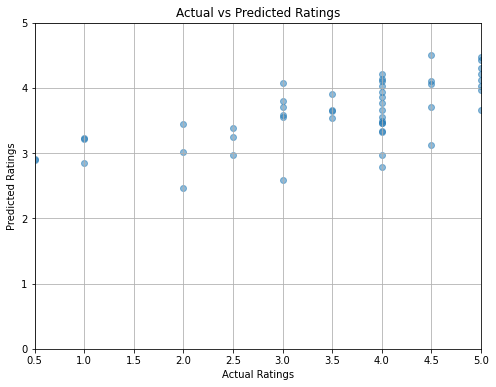

In [14]:
import random
import matplotlib.pyplot as plt

def test_(movies_df, ratings_df):

    ratings_list = list(ratings_df.to_records(index=False))
    random_ratings = random.sample(ratings_list, 200)

    actual_ratings = [] 
    predicted_ratings = [] 

    for record in random_ratings:
        user_id, movie_id, actual_rating = record
        user_ratings = get_user_ratings(user_id, ratings_df)
        predicted_rating = individual_content_based(user_ratings, movie_id)

        actual_ratings.append(actual_rating)
        predicted_ratings.append(predicted_rating)

    plt.figure(figsize=(8, 6))
    plt.scatter(actual_ratings, predicted_ratings, alpha=0.5)
    plt.xlabel('Actual Ratings')
    plt.ylabel('Predicted Ratings')
    plt.xlim(0.5, 5)
    plt.ylim(0, 5)

    plt.title('Actual vs Predicted Ratings')
    plt.grid(True)
    plt.show()

test_(movies, ratings_df)


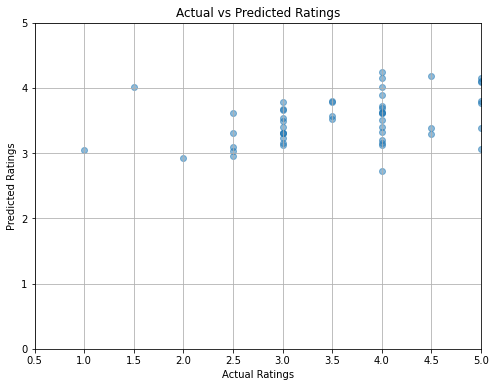

In [106]:
import random
import matplotlib.pyplot as plt

def test_genre_based(movies_df, ratings_df):

    ratings_list = list(ratings_df.to_records(index=False))
    random_ratings = random.sample(ratings_list, 50)

    actual_ratings = [] 
    predicted_ratings = [] 

    for record in random_ratings:
        user_id, movie_id, actual_rating = record
        user_ratings = getUserRatings(user_id, ratings_df)
        predicted_rating = predictRating(user_ratings, movie_id, ratings_df)

        actual_ratings.append(actual_rating)
        predicted_ratings.append(predicted_rating)

    plt.figure(figsize=(8, 6))
    plt.scatter(actual_ratings, predicted_ratings, alpha=0.5)
    plt.xlabel('Actual Ratings')
    plt.ylabel('Predicted Ratings')
    plt.xlim(0.5, 5)
    plt.ylim(0, 5)

    plt.title('Actual vs Predicted Ratings')
    plt.grid(True)
    plt.show()

test_genre_based(movies, ratings_df)


### Indivual Recimmender using KNN

In [10]:
users_ratings = ratings_df.groupby(['userId']).count()

selected = users_ratings['rating'] > 200
selected_users = users_ratings.loc[selected]
random_selected = selected_users.sample() # sample() returns a random row from the dataframe. The returned object is a dataframe with one row. If you pass a number as argument you specify to select more than one row.
select_column_df = random_selected.reset_index()['userId'] # reset_index() create a new index, and the user became a column. Then, we can filter using the column name
selected_user = select_column_df.iloc[0] # iloc select by index, since our dataframe only has one row we read it from the index 0
# selected_user = 19
print("Selected user: " + str(selected_user))

Selected user: 8751


In [11]:
selected_user_ratings = ratings_df.loc[ratings_df['userId'] == selected_user]
selected_user_ratings['item'] = selected_user_ratings.index 
selected_user_ratings.to_csv('selected_user_ratings.csv', index=False)
selected_user_ratings = selected_user_ratings.sort_values(by='item', ascending=True)
print("Rated movies: " + str(selected_user_ratings.shape[0]))
# display(selected_user_ratings.head(10))

Rated movies: 274


C:\Users\Alvaro\AppData\Local\Temp\ipykernel_5340\1963560814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_user_ratings['item'] = selected_user_ratings.index


In [12]:
selected_movie_ids = set(selected_user_ratings['movieId'])
rated_movies_df = movies.reindex(list(selected_user_ratings['movieId']))
# rated_movies_df = movies_df[movies_df['movieId'].isin(selected_movie_ids)]
rated_movies_df = rated_movies_df[['title', 'genres']]
rated_movies_df['item'] = rated_movies_df.index 
rated_movies_df.to_csv('rated_movies_df.csv', index=False)

In [13]:
diff = set(movies.index) - set(rated_movies_df.index)
unrated_movies_df = movies.loc[diff]
# display(unrated_movies_df.head())
unrated_movies_df = unrated_movies_df[['title', 'genres']]
print("Unrated movies: " + str(unrated_movies_df.shape[0]))
# display(unrated_movies_df.head(10))

TypeError: Passing a set as an indexer is not supported. Use a list instead.

In [ ]:
rated_movies_df = rated_movies_df.join(selected_user_ratings.set_index('movieId')['rating'], on='item')
print("Rated movies: " + str(rated_movies_df.shape[0]))
# display(rated_movies_df.head(10))

Rated movies: 780


In [14]:
rated_movies_df['genres'].fillna('', inplace=True)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(rated_movies_df['genres'])
rated_movies_df['genres'].fillna('', inplace=True)
y = rated_movies_df['rating']
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X, y)
X_unrated = vectorizer.transform(unrated_movies_df['genres'])
y_unrated = neigh.predict(X_unrated)
unrated_movies_df['predicted_ratings_KNN'] = y_unrated


KeyError: 'rating'

In [ ]:
user_ratings = movie_ratings  # Use the provided 'movie_ratings' dictionary

# Train a KNN model to predict ratings
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(rated_movies_df['genres'])
y = rated_movies_df['rating']

neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X, y)

#Predict ratings for unrated movies
X_unrated = vectorizer.transform(unrated_movies_df['genres'])
y_unrated = neigh.predict(X_unrated)

#Dictionary with movie IDs and predicted ratings
predicted_ratings = {}
for idx, movie_id in enumerate(unrated_movies_df.index):
    predicted_ratings[movie_id] = y_unrated[idx]

user_and_predicted_ratings = {**user_ratings, **predicted_ratings}

# Sort the movies based on the combined ratings
sorted_movies = sorted(user_and_predicted_ratings.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 recommended movies
print("Top 10 Recommended Movies:")
for i, (movie_id, rating) in enumerate(sorted_movies[:10], 1):
    print(f"{i}. Movie ID: {movie_id}, Rating: {rating}")
for i, (movie_id, rating) in enumerate(sorted_movies[:10], 1):
    print(f"{i}. Movie : {get_movie_name(movie_id)}, Rating: {rating}")

Top 10 Recommended Movies:
1. Movie ID: 6377, Rating: 5.0
2. Movie ID: 12460, Rating: 4.2
3. Movie ID: 14325, Rating: 4.2
4. Movie ID: 3842, Rating: 4.1
5. Movie ID: 8282, Rating: 4.1
6. Movie ID: 11187, Rating: 4.1
7. Movie ID: 13522, Rating: 4.1
8. Movie ID: 15031, Rating: 4.1
9. Movie ID: 15269, Rating: 4.1
10. Movie ID: 15319, Rating: 4.1
1. Movie : Finding Nemo (2003), Rating: 5.0
2. Movie : Movie not in the list, Rating: 4.2
3. Movie : Movie not in the list, Rating: 4.2
4. Movie : Movie not in the list, Rating: 4.1
5. Movie : Movie not in the list, Rating: 4.1
6. Movie : Movie not in the list, Rating: 4.1
7. Movie : Movie not in the list, Rating: 4.1
8. Movie : Movie not in the list, Rating: 4.1
9. Movie : Movie not in the list, Rating: 4.1
10. Movie : Movie not in the list, Rating: 4.1


## Group Recommender system
In this case I decided not to ask the users for the ratings because it is counterproductive. In this case, the group ratings will be already defined in the code


In [ ]:
#Some random group users movie ratings
group_movie_ratings = [
    {1: 5, 2: 3, 13: 4, 3: 4.5},
    {190: 2, 9372: 4, 837: 1.5},
    {89: 3.5, 7521: 3, 90: 3.5}
]

In [ ]:
#----------------------------ADD YOUR WORK HERE-----------------------------
print("ADD HERE YOUR MOVIE RECOMMENDATIONS BASED ON \'group_movie_ratings\'")
print('ADD HERE YOUR EXPLANATION ON THE MOVIE RECOMMENDATIONS')
#----------------------------ADD YOUR WORK HERE-----------------------------

ADD HERE YOUR MOVIE RECOMMENDATIONS BASED ON 'group_movie_ratings'
ADD HERE YOUR EXPLANATION ON THE MOVIE RECOMMENDATIONS
